In [120]:
## import torch
import numpy as np
import matplotlib.pyplot as plt
import os

%load_ext autoreload
%autoreload 1
%aimport active_learning
from active_learning import step_GP, append_data, save_diagnostics, predict_posterior, plot_2D
from data_readers import read_print_data
import torch
torch.manual_seed(10)

# Parameters
MAXIMIZE = False
ACQ = 'EI'
UCB_BETA = 8 #only used if ACQ is UCB
BATCH = 6
N_STEPS = 20
SAVE_PATH = 'print_results'
FILE_NAME = 'print'
DISCRETE = False

# 1) Define your bounds: [min,max] for each of the 4 dims

bounds = torch.tensor([
    [5,  5,  5.0,  5.0],   # lowers: speed, power, print passes, sinter passes
    [20,  20, 60.0, 60],   # uppers
], dtype=torch.float64)

# 2) Build a 1D grid for each axis from bounds of shape (2,4)
num_pts = 15
x0 = torch.linspace(bounds[0, 0], bounds[1, 0], 20, dtype=torch.float64)  # speed
x1 = torch.linspace(bounds[0, 1], bounds[1, 1], 15, dtype=torch.float64)  # sinter power
x2 = torch.linspace(bounds[0, 2], bounds[1, 2], 7, dtype=torch.float64)  # printing passes
x3 = torch.linspace(bounds[0, 3], bounds[1, 3], 5, dtype=torch.float64)  # sinter passes

# 3) Create the 4D mesh
X0, X1, X2, X3 = torch.meshgrid(x0, x1, x2, x3, indexing="ij")

# 4) Flatten and stack into a (num_pts**4, 4) test set
X_test = torch.stack([
    X0.reshape(-1),
    X1.reshape(-1),
    X2.reshape(-1),
    X3.reshape(-1),
], dim=-1)

TARGET_RESISTANCE = np.log([0.5]) #ohms
results_file = 'print_results/Sample Data 5_10_25.xlsx'
X, measured, measured_std = read_print_data(results_file)
log_measured = torch.log(measured)
Y = (log_measured - TARGET_RESISTANCE)**2

measured_var = torch.log(Y_std).pow(2)/5 #sample variance

#convert the measurement variance to MSE space with the delta method
grad = 2*(measured - TARGET_RESISTANCE)
Y_var = measured_var#grad.pow(2)*measured_var

x_next, mean, var, acq = step_GP(
    X=X, Y=Y, X_test=X_test, bounds=bounds,
    Y_var=Y_var,
    acq_func=ACQ, beta=UCB_BETA,
    batch=BATCH,
    maximize=MAXIMIZE,
    discrete=DISCRETE,
    num_restarts=10,
    raw_samples=100,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
X: torch.Size([53, 4]), Y: torch.Size([53, 1]), Y_var: torch.Size([53, 1])


C:\Users\fqh\AppData\Local\Temp\ipykernel_10428\565267546.py:53: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Y = (log_measured - TARGET_RESISTANCE)**2
C:\Users\fqh\AppData\Local\Temp\ipykernel_10428\565267546.py:58: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  grad = 2*(measured - TARGET_RESISTANCE)


Calculating Acquisition...
Finished calculating Acquisition.
0 of 10500


C:\Users\fqh\AppData\Local\anaconda3\envs\basenv\Lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


10000 of 10500


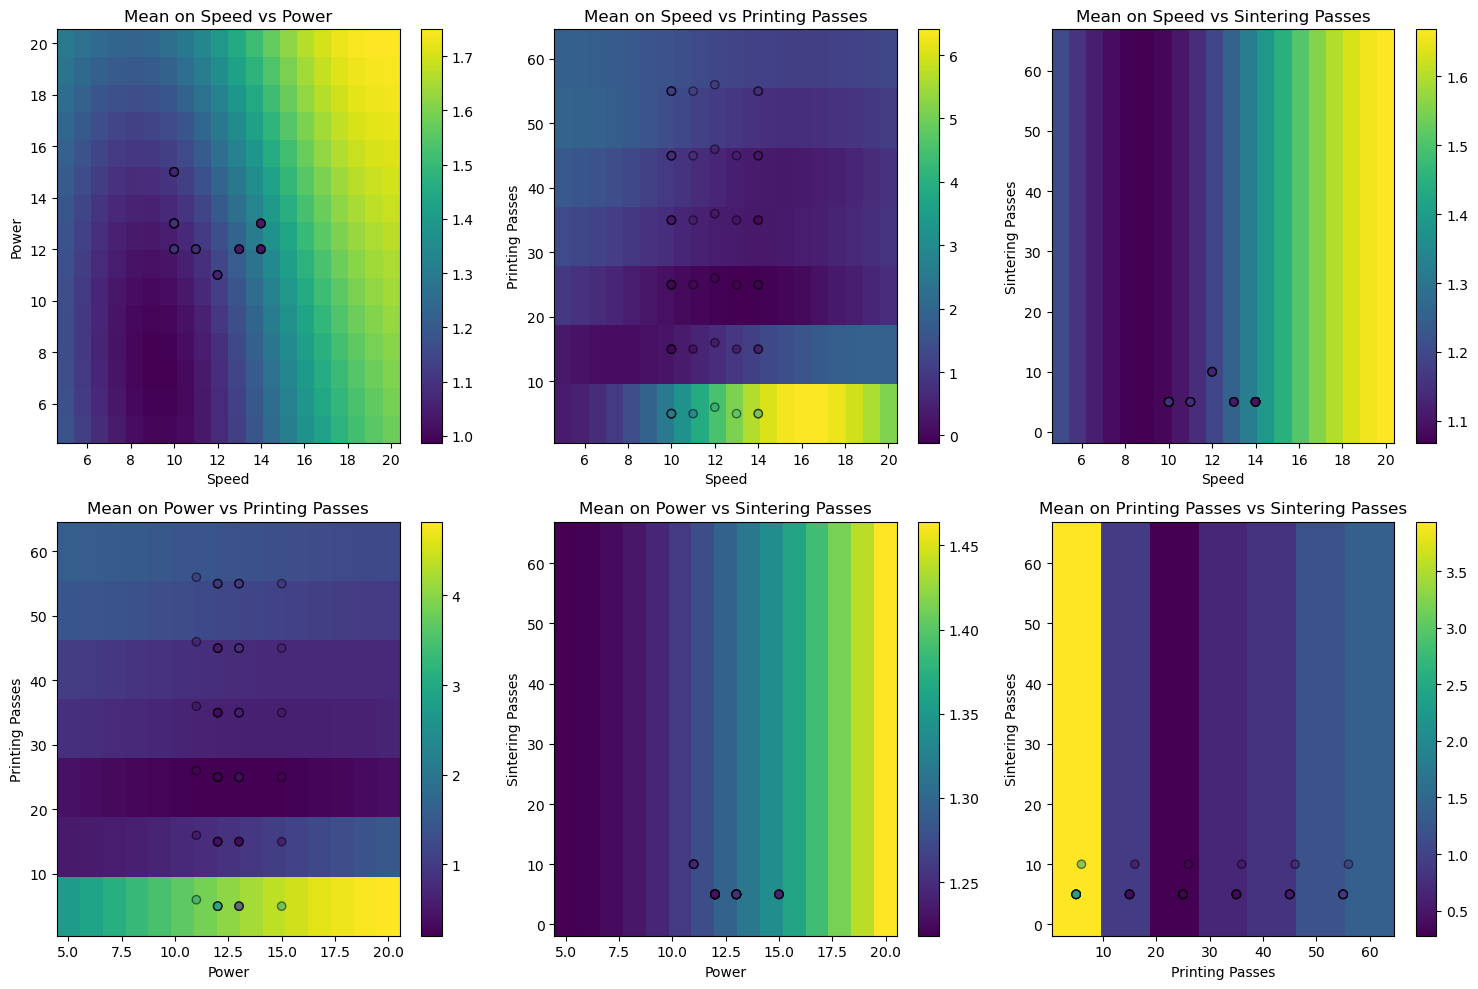

In [118]:
import itertools
def plot_gp_mean_projections(
    mean: torch.Tensor,
    grids: list,
    X_train: torch.Tensor,
    Y_train: torch.Tensor,
    param_names: list[str] = None,
    figsize=(15, 10),
):
    """
    mean_4d:   numpy array of shape (n0,n1,n2,n3) giving the posterior mean.
    grids:     list of four 1-D arrays [g0, g1, g2, g3], where gi.shape == (ni,)
    X_train:   torch.Tensor of shape (N,4)   — the observed inputs
    Y_train:   torch.Tensor of shape (N,1)   — the observed outputs
    param_names: optional list of 4 strings for axis labels
    """
    x0_shape=x0.shape[-1]
    x1_shape=x1.shape[-1]
    x2_shape=x2.shape[-1]
    x3_shape=x3.shape[-1]
    mean_4d = mean.numpy().reshape(x0_shape,x1_shape,x2_shape,x3_shape)
    
    if param_names is None:
        param_names = [f"x{i}" for i in range(4)]
    combos = list(itertools.combinations(range(4), 2))  # [(0,1),(0,2),...,(2,3)]
    
    fig, axes = plt.subplots(2, 3, figsize=figsize, squeeze=False)
    for idx, (i, j) in enumerate(combos):
        ax = axes[idx // 3][idx % 3]
        
        # average the mean over the two axes we're NOT plotting
        other_axes = [k for k in range(4) if k not in (i, j)]
        proj = mean_4d.mean(axis=tuple(other_axes))  # shape (ni, nj)
        
        # build the 2D mesh for dims i,j
        gi = grids[i]
        gj = grids[j]
        Gi, Gj = np.meshgrid(gi, gj, indexing="ij")  # both shape (ni, nj)
        
        pcm = ax.pcolormesh(Gi, Gj, proj, shading="nearest")
        ax.scatter(
            X_train[:, i].numpy(),
            X_train[:, j].numpy(),
            c=Y_train.squeeze(-1).numpy(),
            edgecolor="k",
            cmap="viridis",
            alpha=0.5,
        )
        ax.set_xlabel(param_names[i])
        ax.set_ylabel(param_names[j])
        ax.set_title(f"Mean on {param_names[i]} vs {param_names[j]}")
        fig.colorbar(pcm, ax=ax)
    
    plt.tight_layout()
    plt.show()

plot_gp_mean_projections(
    mean=mean,
    grids= [x0,x1,x2,x3],
    X_train=X,
    Y_train=Y,
    param_names=['Speed','Power','Printing Passes','Sintering Passes'],
    figsize=(15, 10)
)